# TODO


* Check BF's and effect sizes using weaker/stronger priors (probably won't have any effect here, except maybe for max-d in mouse data with CoMs)
* Calculate BF's using ten independent fits (would take 10x time, only do when finalizing the paper submission)

Exploratory analyses
* Run exploratory analysis of trajectory entropy (Calcagni et al 2017, http://polorovereto.unitn.it/~antonio.calcagni/emot.html)
* Run decision landscapes (compare three tertiles of $\Delta$ (SS left, LL right), compare strong discounters to weak discounters, compare walking vs mouse, 1st task vs 2nd task) 

# Contents

* [Preregistered analysis](#prereg)
  * [Mouse-tracking task](#mouse) 
    * [Max-d](#mouse_max_d)
    * [Response time](#mouse_RT)
  * [Walking task](#walking) 
    * [Max-d](#walking_max_d)
    * [Response time](#walking_RT)
  * [Effect of changes-of-mind](#com)
    * [Mouse-tracking](#com_mouse)
    * [Walking](#com_walking)
  * [Frequentist regressions](#freq)
* [Exploratory analysis](#explore)

In [1]:
library(tmvtnorm)
library(ggplot2)
library(ggExtra)
library(brms)
library(reshape2)
library(coda)
library(mefa)
library(tidybayes)
library(ggstance)
library(viridis)
library(latex2exp)
library(ggthemes)
library(data.table)
library(bayesplot)
library(diptest)

# data_path = "../data/choices_processed.txt"
data_path = "C:/Users/Arkady/Google Drive/data/beyond_the_reach"
figure_path = "C:/Users/Arkady/Dropbox/Research/Journal papers/2018 Beyond the reach/figures"
table_path = "C:/Users/Arkady/Dropbox/Research/Journal papers/2018 Beyond the reach/tables"

figure_format = "png"

Loading required package: mvtnorm
Loading required package: Matrix
Loading required package: stats4
Loading required package: gmm
Loading required package: sandwich
Loading required package: Rcpp
Loading 'brms' package (version 2.4.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').
Run theme_set(theme_default()) to use the default bayesplot theme.
mefa 3.2-7 	 2016-01-11

Attaching package: 'mefa'

The following object is masked from 'package:reshape2':

    melt

NOTE: As of tidybayes version 1.0, several functions, arguments, and output column names
      have undergone significant name changes in order to adopt a unified naming scheme.
      See help('tidybayes-deprecated') for more information.


Attaching package: 'ggstance'

The following objects are masked from 'package:ggplot2':

    geom_errorbarh, GeomErrorbarh

Loading required package: viridisLite

Attaching package: 'data.

Load processed data

In [2]:
get_processed_data <- function(data_path){
    filename <- file.path(data_path, "choices_processed.txt")
    data <- read.table(filename, header = TRUE, sep = ",")
    data[, "subj_id"] <- as.factor(data[, "subj_id"])
    data[, "option_chosen"] <- as.factor(data[, "option_chosen"])
    
    return(data)
}

In [3]:
data <- get_processed_data(data_path)
mouse_data <- data[data$task=="mouse",]
walking_data <- data[data$task=="walking",]

Define the functions used throughout the notebook

In [13]:
get_bf_dyn <- function(models, data, formulas, prior){ 
    " This function fits three models to the supplied data, and returns these models with pairwise BF's"
    m_inter <- fit_model(models$m_inter, data, formulas$f_inter, prior)
    m_choice <- fit_model(models$m_choice, data, formulas$f_choice, prior[1,])
    m_null <- fit_model(models$m_null, data, formulas$f_null, prior[1,])
    
    bf <- t(c(bayes_factor(x1 = m_choice, x2 = m_null)$bf,
              bayes_factor(x1 = m_inter, x2 = m_null)$bf,
              bayes_factor(x1 = m_inter, x2 = m_choice)$bf))
    ci_inter <- HPDinterval(as.mcmc(m_inter, combine_chains = TRUE))
    
    result = list(bf = bf, models = list(m_null = m_null, m_choice = m_choice, m_inter = m_inter), ci_inter = ci_inter)
    
    return(result)
}

fit_model <- function(model, data, formula, prior){
    " This function updates the brms model if it exists (to avoid slow recompilation of the C++ model by Stan), 
    or creates a model from scratch if it doesn't exist yet "
    if(!is.null(model)){
        model <- update(model, newdata = data, recompile = F)        
    } else {
        model <- brm(formula, data = data, family = gaussian(), save_all_pars = TRUE,
                   control = list(adapt_delta = 0.99), prior = prior)
    }
    return(model)
}

run_analysis <- function(dv, iv, data, rscale){
    " This function runs our analysis for a given dataset (fake or real) and given dependent and 
    independent variables (dv and iv). Tscale parameter defines the scale of prior distribution on regression slopes (see Rouder & Morey (2012))"
    models <- list(m_inter = NULL, m_choice = NULL, m_null = NULL)

    " Priors on centered intercepts are the values of DV when all predictors are at their means (see brms docs).
    brms accepts priors on non-standardized b coefficients. We compute them by scaling default priors on standardized 
    coefficients (Rouder & Morey, 2012) to sd(DV)/sd(IV)"
    prior <- c(set_prior(sprintf('normal(%f, %f)', mean(data[, dv]), sd(data[, dv])), class = "Intercept"),
               set_prior(sprintf('cauchy(0, %f)', rscale*sd(data[, dv])/sd(data[, iv])), class = "b"))

    interaction_term = paste(iv, "option_chosen", sep=':')
    formulas <- list(f_inter = as.formula(paste(dv, "~ (option_chosen | subj_id) +", interaction_term)),
                     f_choice = as.formula(paste(dv, "~ (option_chosen | subj_id)")),
                     f_null = as.formula(paste(dv, "~ (1 | subj_id)")))

    bf_result <- get_bf_dyn(models, data, formulas, prior)
    
    return(bf_result)
}

spaghetti_plot <- function(model, data, dv, iv, file_name){
    plt <- plot(marginal_effects(model, spaghetti=TRUE, nsamples=300), plot=FALSE)
    plt <- plt[[1]] + 
        geom_point(aes_string(x=iv, y=dv, shape='option_chosen', colour='option_chosen'), 
                   size = 3, alpha=0.1, data = data) +
        theme_pander(base_size = 14) +
        xlab(TeX("Relative advantage of LL option")) +
        ylab(dv) +
        scale_color_viridis(discrete=TRUE, alpha=0.2, begin=0.0, end=0.7)
    
    ggsave(file.path(figure_path, file_name), dpi=150, width=8, height=4) 
}

joyplot <- function(model, file_name){
    m <- as.matrix(as.mcmc(model, combine_chains = FALSE))

    # Only keep the choice-by-lambda interaction parameters    
    m <- m[,grep(",option_chosen", colnames(m))]
    
    # Reformat column names
    colnames(m) <- sub("r_subj_id\\[", "s", colnames(m))
    colnames(m) <- sub(",option_chosenss]", "", colnames(m))
    
    # Reorder columns(parameters) by their mean values and plot the result        
    plt <- mcmc_areas_ridges(m[,order(colMeans(m))])#, prob=0.95)
    
    plt <- plt + theme_pander(base_size = 12) +
        xlab("Offset of regression coefficient for SS choices") #+
#         scale_color_manual(values = c("#D55E00", "#0072B2"), guide = "none")
#     +
#        scale_color_viridis(discrete=TRUE, alpha=0.4, begin=0.0, end=0.7)
    ggsave(file.path(figure_path, file_name), dpi=150, width=4, height=8)
}

posterior_plot <- function(model, iv, file_name){
    plot <- mcmc_areas_ridges(as.matrix(as.mcmc(model, combine_chains = TRUE)), 
                              regex_pars = paste("b_", iv, ":option_chosen", sep=""), prob=0.95)
    ggsave(file.path(figure_path, file_name), dpi=150, width=8, height=4)
}

save_posterior <- function(model, file_name){    
    write.csv(as.matrix(as.mcmc(model, combine_chains=TRUE)), file=file.path("csv", file_name), row.names=FALSE)
}

visualize_model <- function(model, data, task, dv, iv, figure_format){
    spaghetti_plot(model, data, dv, iv, file_name=sprintf("spaghetti_%s_%s.%s", task, dv, figure_format))
    joyplot(model, file_name=sprintf("joy_%s_%s.%s", task, dv, figure_format))
    posterior_plot(model, iv, file_name=sprintf("posterior_%s_%s.%s", task, dv, figure_format))
    save_posterior(model, file_name = sprintf("posterior_%s_%s.%s", task, dv, "csv"))
}

print_bf <- function(bf_result, analysis_name){
    print(analysis_name)
    print(sprintf("BF of choice model over null model: %g", bf_result$bf[1]))
    print(sprintf("BF of choice-by-delta model over null model: %g", bf_result$bf[2]))
    print(sprintf("BF of choice-by-delta model over choice-only model: %g", bf_result$bf[3]))
    
    print(bf_result$ci[c(paste("b_", iv, ":option_chosenll", sep=""), paste("b_", iv, ":option_chosenss", sep="")),])

}

# Preregistered analysis <a class="anchor" id="prereg"></a>

## Mouse-tracking task<a class="anchor" id="mouse"></a>

### Mouse-tracking task: max-d<a class="anchor" id="mouse_max_d"></a>

In [11]:
mouse_max_d_bf <- run_analysis("max_d", "Delta", mouse_data, 0.707)
# mouse_max_d_bf_narrow_prior <- run_analysis("max_d", mouse_data, 0.5)
# mouse_max_d_bf_wide_prior <- run_analysis("max_d", mouse_data, 1.0)

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0.003 seconds
1000 transitions using 10 leapfrog steps per transition would take 30 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 85.051 seconds (Warm-up)
               44.179 seconds (Sampling)
               129.23 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.


Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0.016 seconds
1000 transitions using 10 leapfrog steps per transition would take 160 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 53.97 seconds (Warm-up)
               25.852 seconds (Sampling)
               79.822 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.


Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0.004 seconds
1000 transitions using 10 leapfrog steps per transition would take 40 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 15.15 seconds (Warm-up)
               12.829 seconds (Sampling)
               27.979 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
A

In [14]:
print_bf(mouse_max_d_bf, "mouse task max-d analysis")

[1] "mouse task max-d analysis"
[1] "BF of choice model over null model: 4.04129e+74"
[1] "BF of choice-by-delta model over null model: 6.6596e+83"
[1] "BF of choice-by-delta model over choice-only model: 1.83676e+09"
                            lower     upper
b_Delta:option_chosenll -100.5302 -41.85517
b_Delta:option_chosenss   34.0749  68.56549


BF's for Lambda: 3.316738e+74	2.7681e+75 	7.228917 

In [9]:
visualize_model(mouse_max_d_bf$models$m_inter, mouse_data, "mouse", "max_d", "Delta", figure_format)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


                             lower     upper
b_Delta:option_chosenll -102.14931 -43.21097
b_Delta:option_chosenss   34.10009  68.44165



### Mouse-tracking task: response time<a class="anchor" id="mouse_RT"></a>

In [79]:
mouse_rt_bf <- run_analysis("RT", "Delta", mouse_data, 0.707)

Warning message in file(file, ifelse(append, "a", "w")):
"cannot open file 'C:\Users\Arkady\AppData\Local\Temp\Rtmp6BbQ8m\filedf816393ab5.stan': No such file or directory"

ERROR: Error in file(file, ifelse(append, "a", "w")): cannot open the connection


In [64]:
print_bf(mouse_RT_bf$bf, "mouse task RT analysis")

[1] "mouse task RT analysis"
[1] "BF of choice model over null model: 9.06267e+07"
[1] "BF of choice-by-delta model over null model: 1.19852e+47"
[1] "BF of choice-by-delta model over choice-only model: 1.47799e+39"


In [12]:
visualize_model(mouse_rt_bf$models$m_inter, mouse_data, "mouse", "RT", "Delta", figure_format)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


                             lower      upper
b_Delta:option_chosenll -1.4264861 -0.9260674
b_Delta:option_chosenss  0.7126629  1.0004242


## Walking<a class="anchor" id="walking"></a>

### Walking task: max-d<a class="anchor" id="walking_max_d"></a>

In [13]:
walking_max_d_bf <- run_analysis("max_d", "Delta", walking_data, 0.707)

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 25.608 seconds (Warm-up)
               12.236 seconds (Sampling)
               37.844 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjus

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 20.242 seconds (Warm-up)
               8.871 seconds (Sampling)
               29.113 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 7.47 seconds (Warm-up)
               4.457 seconds (Sampling)
               11.927 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust y

In [14]:
print_bf(walking_max_d_bf$bf, "walking task max-d analysis")

9.021859e+67,8.234433e+82,8.953242e+14


In [15]:
visualize_model(walking_max_d_bf$models$m_inter, walking_data, "walking", "max_d", "Delta", figure_format)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


                              lower       upper
b_Delta:option_chosenll -0.13294832 -0.07521067
b_Delta:option_chosenss  0.04038452  0.07694741


### Walking task: response time<a class="anchor" id="walking_RT"></a>

In [16]:
walking_rt_bf <- run_analysis("RT", "Delta", walking_data, 0.707)

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 31.426 seconds (Warm-up)
               21.266 seconds (Sampling)
               52.692 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjus

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 22.249 seconds (Warm-up)
               25.527 seconds (Sampling)
               47.776 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjus

Warning message:
"There were 3 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 5.561 seconds (Warm-up)
               4.917 seconds (Sampling)
               10.478 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust 

In [17]:
walking_rt_bf$bf

1.98446e+11,3.124144e+35,1.514306e+24


In [18]:
visualize_model(walking_rt_bf$models$m_inter, walking_data, "walking", "RT", "Delta", figure_format)
# spaghetti_plot(walking_rt_bf$models$m_inter, "RT", "RT", "spaghetti_walking_RT.png")
# joyplot(walking_rt_bf$models$m_inter, "joy_walking_RT.png")
# posterior_plot(walking_rt_bf$models$m_inter, file_name = "posterior_walking_RT.png")
# save_posterior(walking_rt_bf$models$m_inter, file_name = "posterior_walking_RT.csv")

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


                             lower      upper
b_Delta:option_chosenll -0.8185506 -0.5041573
b_Delta:option_chosenss  0.3248203  0.5173814


## Effect of changes-of-mind on max-d analysis<a class="anchor" id="com"></a>

Checking for unimodality of the max-d distributions

In [19]:
print(dip.test(mouse_data$max_d, simulate.p.value = TRUE))
print(dip.test(walking_data$max_d, simulate.p.value = TRUE))


	Hartigans' dip test for unimodality / multimodality with simulated
	p-value (based on 2000 replicates)

data:  mouse_data$max_d
D = 0.0052932, p-value = 0.97
alternative hypothesis: non-unimodal, i.e., at least bimodal


	Hartigans' dip test for unimodality / multimodality with simulated
	p-value (based on 2000 replicates)

data:  walking_data$max_d
D = 0.0061884, p-value = 0.837
alternative hypothesis: non-unimodal, i.e., at least bimodal



Hartigans' dip test doesn't provide evidence in favor of multimodality. Still, the histograms of max-d for the walking task reveal that there are at least two distinct clusters of trajectories. For this reason, we check the robustness of the max-d analysis using a subset of trajectories which exclude changes-of-mind (CoM; see preprocessing notebook for a criterion used to detect CoMs)

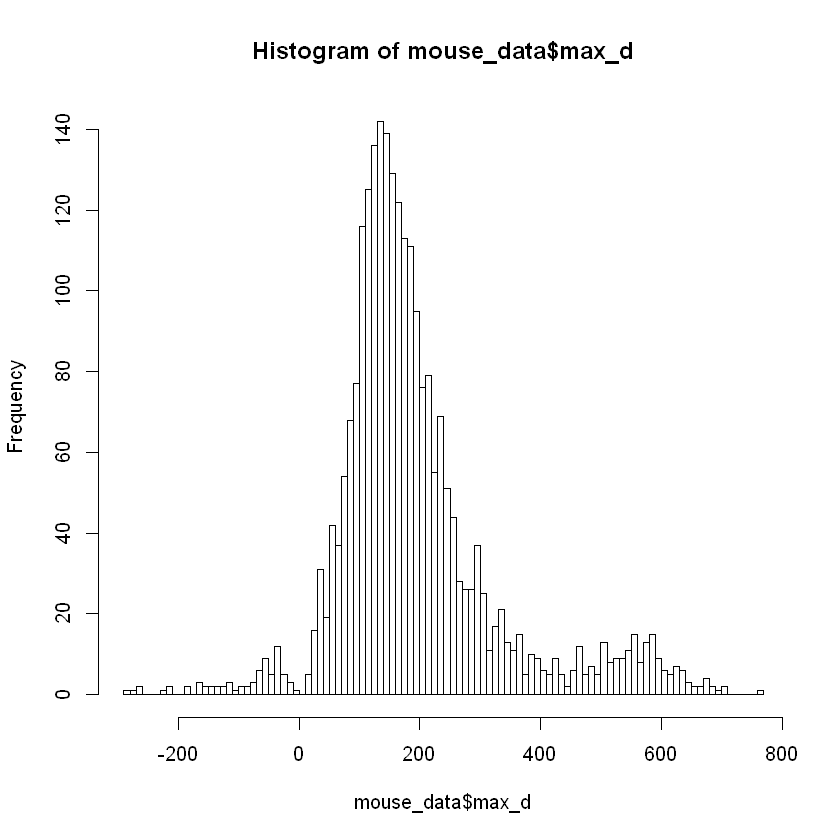

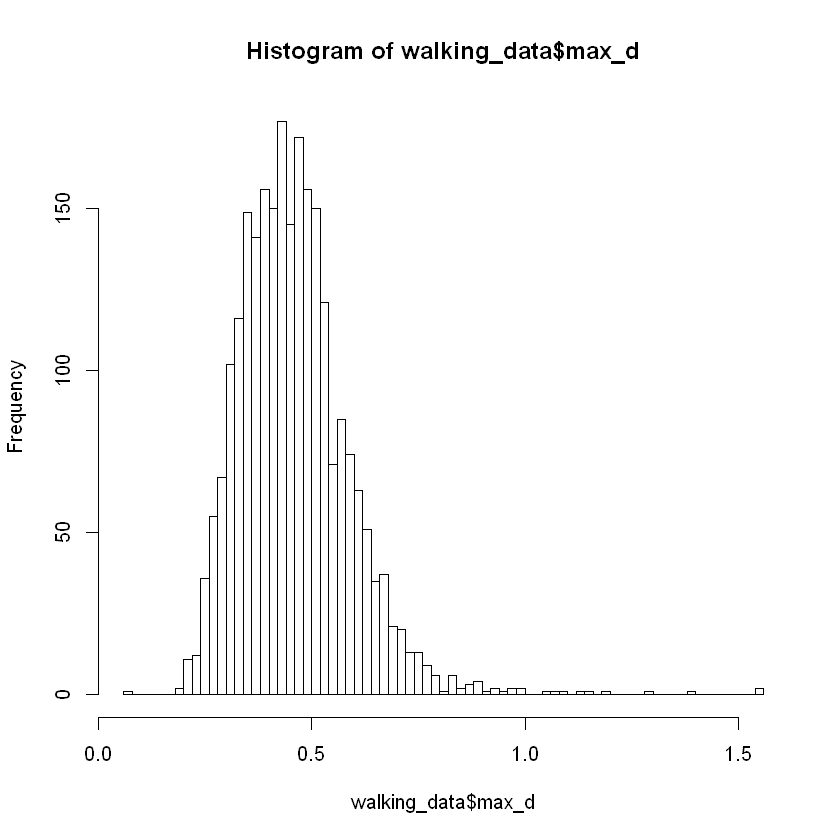

In [20]:
hist(mouse_data$max_d, breaks = 100, freq = TRUE)
hist(walking_data$max_d, breaks = 100, freq = TRUE)

In [21]:
mouse_data_no_com <- mouse_data[mouse_data$is_com=="False",]
walking_data_no_com <- walking_data[walking_data$is_com=="False",]

### Effects of CoM: mouse-tracking task<a class="anchor" id="mouse_com"></a>

In [22]:
mouse_max_d_no_com_bf <- run_analysis("max_d", "Delta", mouse_data_no_com, 0.707)

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 25.746 seconds (Warm-up)
               18.256 seconds (Sampling)
               44.002 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjus

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 21.214 seconds (Warm-up)
               14.384 seconds (Sampling)
               35.598 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjus

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 4.133 seconds (Warm-up)
               4.071 seconds (Sampling)
               8.204 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust y

In [29]:
print_bf(mouse_max_d_no_com_bf, "mouse task max-d analysis (changes-of-mind excluded)")

[1] "mouse task max-d analysis (changes-of-mind excluded)"
[1] "BF of choice model over null model: 9.3494e+58"
[1] "BF of choice-by-delta model over null model: 7.85223e+59"
[1] "BF of choice-by-delta model over choice-only model: 6.38534"
NULL


In [24]:
visualize_model(mouse_max_d_no_com_bf$models$m_inter, mouse_data_no_com, 
                "mouse_no_com", "max_d", "Delta", figure_format)

# spaghetti_plot(mouse_max_d_no_com_bf$models$m_inter, "RT", "RT", "spaghetti_mouse_max_d_no_com.png")
# joyplot(mouse_max_d_no_com_bf$models$m_inter, "joy_mouse_max_d_no_com.png")
# posterior_plot(mouse_max_d_no_com_bf$models$m_inter, file_name = "posterior_mouse_max_d_no_com.png")
# save_posterior(mouse_max_d_no_com_bf$models$m_inter, file_name = "posterior_mouse_max_d_no_com.csv")

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


                             lower     upper
b_Delta:option_chosenll -41.044236 -5.412343
b_Delta:option_chosenss   8.179552 28.642559


### Effects of CoM: walking task<a class="anchor" id="walking_com"></a>

In [25]:
walking_max_d_no_com_bf <- run_analysis("max_d", "Delta", walking_data_no_com, 0.707)

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0.002 seconds
1000 transitions using 10 leapfrog steps per transition would take 20 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 29.899 seconds (Warm-up)
               18.926 seconds (Sampling)
               48.825 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.


Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 22.275 seconds (Warm-up)
               8.979 seconds (Sampling)
               31.254 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 8.077 seconds (Warm-up)
               4.411 seconds (Sampling)
               12.488 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust 

In [28]:
print_bf(walking_max_d_no_com_bf, "walking task max-d analysis (changes-of-mind excluded)")

[1] "walking task max-d analysis (changes-of-mind excluded)"
[1] "BF of choice model over null model: 3.38894e+58"
[1] "BF of choice-by-delta model over null model: 5.55176e+72"
[1] "BF of choice-by-delta model over choice-only model: 1.46766e+14"
NULL


In [27]:
visualize_model(walking_max_d_no_com_bf$models$m_inter, walking_data_no_com, 
                "walking_no_com", "max_d", "Delta", figure_format)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


                              lower       upper
b_Delta:option_chosenll -0.10954017 -0.05909662
b_Delta:option_chosenss  0.03570159  0.06861415


## Frequentist regressions<a class="anchor" id="freq"></a>

Just to check whether the results of Bayesian regressions are consistent with their frequentist counterparts. In all cases (max-d/RT, mouse/walking), the models involving choice-by-$\Delta$ interaction are most supported by the data. 

However, in mouse data without changes-of-mind, the choice-only model is most likely.

In [17]:
library(coin)
library(lme4)
library(lmerTest)
library(plyr)
library(xtable)
library(LMERConvenienceFunctions)
library(car)

Warning message:
"package 'coin' was built under R version 3.5.2"Loading required package: survival

Attaching package: 'survival'

The following object is masked from 'package:brms':

    kidney


Attaching package: 'lme4'

The following object is masked from 'package:brms':

    ngrps

The following object is masked from 'package:gmm':

    checkConv

Warning message:
"package 'lmerTest' was built under R version 3.5.2"
Attaching package: 'lmerTest'

The following object is masked from 'package:lme4':

    lmer

The following object is masked from 'package:stats':

    step


Attaching package: 'xtable'

The following objects are masked from 'package:mefa':

    label, label<-

Loading required package: carData


### Mouse-tracking task: response time

In [18]:
rt_mouse_analysis <- function(stats.df){
    choice.mer = lmer(RT ~ (option_chosen | subj_id) + option_chosen:Delta, stats.df)
    print(summary(choice.mer))

    choice.output = summary(choice.mer)$coefficients

    file_name = file.path(table_path, "RT_vs_Delta_mouse.tex")
    print(xtable(choice.output, digits = c(2,2,2,2,2,-2), 
                 label = "tab:freq_RT_vs_Delta_mouse",
                 caption = "Response time as a function of $\\Delta$ and choice"), 
          math.style.exponents = TRUE, type = "latex", file = file_name)
}


In [19]:
rt_mouse_analysis(mouse_data)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RT ~ (option_chosen | subj_id) + option_chosen:Delta
   Data: stats.df

REML criterion at convergence: 6779.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5195 -0.5786 -0.1349  0.3994  4.9148 

Random effects:
 Groups   Name            Variance Std.Dev. Corr 
 subj_id  (Intercept)     0.74661  0.8641        
          option_chosenss 0.08848  0.2975   -0.81
 Residual                 0.81829  0.9046        
Number of obs: 2490, groups:  subj_id, 54

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)              2.94760    0.09476   67.72971  31.107   <2e-16 ***
option_chosenll:Delta   -1.18855    0.12880 1721.72225  -9.228   <2e-16 ***
option_chosenss:Delta    0.85930    0.07116 1107.77160  12.076   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
             (In

### Mouse-tracking task: max-d

In [20]:
max_d_mouse_analysis <- function(stats.df){
    choice.mer = lmer(max_d ~ (option_chosen | subj_id) + option_chosen:Delta, stats.df)
    print(summary(choice.mer))

    choice.output = summary(choice.mer)$coefficients

    file_name = file.path(table_path, "max_d_vs_Delta_mouse.tex")
    print(xtable(choice.output, digits = c(2,2,2,2,2,-2), 
                 label = "tab:freq_max_d_vs_lambda_mouse",
                 caption = "Maximum deviation as a function of $\\Delta$ and choice"), 
          math.style.exponents = TRUE, type = "latex", file = file_name)
}

In [23]:
max_d_mouse_analysis(mouse_data)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: max_d ~ (option_chosen | subj_id) + option_chosen:Delta
   Data: stats.df

REML criterion at convergence: 30358.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.7960 -0.4696 -0.1000  0.2916  6.5699 

Random effects:
 Groups   Name            Variance Std.Dev. Corr 
 subj_id  (Intercept)      9137     95.59        
          option_chosenss 10643    103.16   -0.58
 Residual                 10307    101.52        
Number of obs: 2490, groups:  subj_id, 54

Fixed effects:
                      Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)            217.790     11.004   57.036  19.792  < 2e-16 ***
option_chosenll:Delta  -72.583     15.193 2440.899  -4.777 1.88e-06 ***
option_chosenss:Delta   52.075      8.738 2382.530   5.960 2.91e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
             (Intr) optn_chs

The effect of $\Delta$ on max-d is significant, but only for both SS and LL choices. Now try excluding changes-of-mind

In [22]:
max_d_mouse_analysis(mouse_data_no_com)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: max_d ~ (option_chosen | subj_id) + option_chosen:Delta
   Data: stats.df

REML criterion at convergence: 25276.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.9249 -0.5078 -0.0418  0.4489  7.8043 

Random effects:
 Groups   Name            Variance Std.Dev. Corr 
 subj_id  (Intercept)     4718     68.69         
          option_chosenss 4001     63.26    -0.59
 Residual                 3652     60.43         
Number of obs: 2263, groups:  subj_id, 54

Fixed effects:
                      Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)            171.625      7.800   56.311  22.005  < 2e-16 ***
option_chosenll:Delta  -23.618      9.411 2207.682  -2.510 0.012159 *  
option_chosenss:Delta   18.516      5.357 2167.285   3.457 0.000557 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
             (Intr) optn_chs

The frequentist analysis is consistent with the findings of Bayesian regressions. In the mouse task, the effect of $\Lambda$ on max-d is significant for the LL option, but the evidence of effect diminishes if we exclude changes-of-mind

### Walking data: response times

In [24]:
rt_walking_analysis <- function(stats.df){
    choice.mer = lmer(RT ~ (option_chosen | subj_id) + option_chosen:Delta, stats.df)
    print(summary(choice.mer))

    choice.output = summary(choice.mer)$coefficients

    file_name = file.path(table_path, "RT_vs_Delta_walking.tex")
    print(xtable(choice.output, digits = c(2,2,2,2,2,-2), 
                 label = "tab:freq_RT_vs_Delta_walking",
                 caption = "Response time as a function of $\\Delta$ and choice"), 
          math.style.exponents = TRUE, type = "latex", file = file_name)
}


In [25]:
rt_walking_analysis(walking_data)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RT ~ (option_chosen | subj_id) + option_chosen:Delta
   Data: stats.df

REML criterion at convergence: 4351.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7404 -0.6144 -0.1410  0.4276  6.5473 

Random effects:
 Groups   Name            Variance Std.Dev. Corr 
 subj_id  (Intercept)     0.6044   0.7775        
          option_chosenss 0.0634   0.2518   -0.39
 Residual                 0.3056   0.5528        
Number of obs: 2451, groups:  subj_id, 54

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)              5.02087    0.10024   55.75774  50.087  < 2e-16 ***
option_chosenll:Delta   -0.66817    0.08097 1930.11947  -8.253 2.84e-16 ***
option_chosenss:Delta    0.42293    0.04925 1330.50135   8.587  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
             (In

### Walking task: max-d

In [26]:
max_d_walking_analysis <- function(stats.df){
    choice.mer = lmer(max_d ~ (option_chosen | subj_id) + option_chosen:Delta, stats.df)
    print(summary(choice.mer))

    choice.output = summary(choice.mer)$coefficients

    file_name = file.path(table_path, "max_d_vs_Delta_walking.tex")
    print(xtable(choice.output, digits = c(2,2,2,2,2,-2), 
                 label = "tab:freq_max_d_vs_Delta_mouse",
                 caption = "Maximum deviation as a function of $\\Delta$ and choice"), 
          math.style.exponents = TRUE, type = "latex", file = file_name)
}

In [27]:
max_d_walking_analysis(walking_data)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: max_d ~ (option_chosen | subj_id) + option_chosen:Delta
   Data: stats.df

REML criterion at convergence: -4061.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4194 -0.5830 -0.0616  0.4585 10.0826 

Random effects:
 Groups   Name            Variance Std.Dev. Corr 
 subj_id  (Intercept)     0.007050 0.08396       
          option_chosenss 0.009555 0.09775  -0.45
 Residual                 0.009789 0.09894       
Number of obs: 2451, groups:  subj_id, 54

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            4.848e-01  1.060e-02  5.514e+01  45.754  < 2e-16 ***
option_chosenll:Delta -1.036e-01  1.494e-02  2.396e+03  -6.931 5.34e-12 ***
option_chosenss:Delta  5.792e-02  9.356e-03  2.304e+03   6.191 7.05e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            

# Effect of $\lambda$

In [39]:
run_all_analyses <- function(iv){
    walking_max_d_bf <- run_analysis("max_d", iv, walking_data, 0.707)
    print_bf(walking_max_d_bf$bf)
    visualize_model(walking_max_d_bf$models$m_inter, walking_data, "walking", "max_d", iv, figure_format)
    
    walking_rt_bf <- run_analysis("RT", iv, walking_data, 0.707)
    print_bf(walking_rt_bf$bf)
    visualize_model(walking_RT_bf$models$m_inter, walking_data, "walking", "RT", iv, figure_format)
    
    mouse_max_d_bf <- run_analysis("max_d", iv, mouse_data, 0.707)
    print_bf(mouse_max_d_bf$bf)
    visualize_model(mouse_max_d_bf$models$m_inter, mouse_data, "mouse", "max_d", iv, figure_format)
    
    mouse_rt_bf <- run_analysis("RT", iv, mouse_data, 0.707)
    print_bf(mouse_rt_bf$bf)
    visualize_model(mouse_RT_bf$models$m_inter, mouse_data, "mouse", "RT", iv, figure_format)
    
    walking_max_d_no_com_bf <- run_analysis("max_d", iv, walking_data_no_com, 0.707)
    print_bf(walking_max_d_no_com_bf$bf)
    visualize_model(walking_max_d_no_com_bf$models$m_inter, walking_data_no_com, 
                    "walking_no_com", "max_d", iv, figure_format)    
    
    mouse_max_d_no_com_bf <- run_analysis("max_d", iv, mouse_data_no_com, 0.707)
    print_bf(mouse_max_d_no_com_bf$bf)
    visualize_model(mouse_max_d_no_com_bf$models$m_inter, mouse_data_no_com, 
                    "mouse_no_com", "max_d", iv, figure_format) 
    
    return(list(walking_max_d_bf = walking_max_d_bf, walking_rt_bf = walking_rt_bf, 
                mouse_max_d_bf = mouse_max_d_bf, mouse_rt_bf = mouse_rt_bf, 
                walking_max_d_no_com_bf = walking_max_d_no_com_bf, mouse_max_d_no_com_bf = mouse_max_d_no_com_bf))
}

lambda_results <- run_all_analyses("Lambda")

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 32.675 seconds (Warm-up)
               22.168 seconds (Sampling)
               54.843 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjus

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 22.984 seconds (Warm-up)
               9.296 seconds (Sampling)
               32.28 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust 

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 7.283 seconds (Warm-up)
               5.071 seconds (Sampling)
               12.354 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust 

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


                                lower        upper
b_Lambda:option_chosenll -0.011812553 -0.005097212
b_Lambda:option_chosenss  0.005587456  0.012341290


Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 31.607 seconds (Warm-up)
               21.429 seconds (Sampling)
               53.036 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjus

Warning message:
"There were 4 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 24.573 seconds (Warm-up)
               15.867 seconds (Sampling)
               40.44 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust

Warning message:
"There were 2 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 5.967 seconds (Warm-up)
               4.559 seconds (Sampling)
               10.526 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust 

ERROR: Error in marginal_effects(model, spaghetti = TRUE, nsamples = 300): object 'walking_RT_bf' not found


# Generate latex table

In [35]:
hyp_1_format_string <- "\\begin{table}[]
\\caption{%s}
\\label{%s}
\\begin{tabular}{@{}llll@{}}
\\toprule
 &  & RT & max-d \\\\ \\midrule
\\multirow{2}{*}{walking} & BF & %.6g & %.6g \\\\
 & 0.95 CI &  (%.3f, %.3f) & (%.3f, %.3f) \\\\
\\multirow{2}{*}{mouse} & BF &  &  \\\\
 & 0.95 CI &  &  \\\\ \\cmidrule(l){1-4} 
\\end{tabular}
\\end{table}"

In [37]:
 walking_rt_bf$bf

1.98446e+11,3.124144e+35,1.514306e+24


In [36]:
caption = "Results of testing Hypothesis 1 for the walking and mouse-tracking tasks"
label = "tab:hyp_1_bf"
output <- sprintf(hyp_1_format_string, caption, label, walking_rt_bf$bf[3], 3)

fileConn<-file(file.path(table_path, "hyp_1_delta.tex"))
writeLines(output, fileConn)
close(fileConn)

# Save all results to RData file

In [40]:
save.image()